In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from transformers import DistilBertTokenizer , DistilBertModel, DistilBertConfig, BertConfig
import torch
import torch.nn as nn
from numba import cuda
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification
import re



from tqdm import tqdm
import pickle


from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/MyDrive/gen proj/new'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/gen proj/new


In [2]:
dataset = pd.read_csv('WELFake_Dataset.csv')

In [3]:
print("Total Training Instances: ", len(dataset))

Total Training Instances:  72134


In [4]:
dataset.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


label
1    37106
0    35028
Name: count, dtype: int64


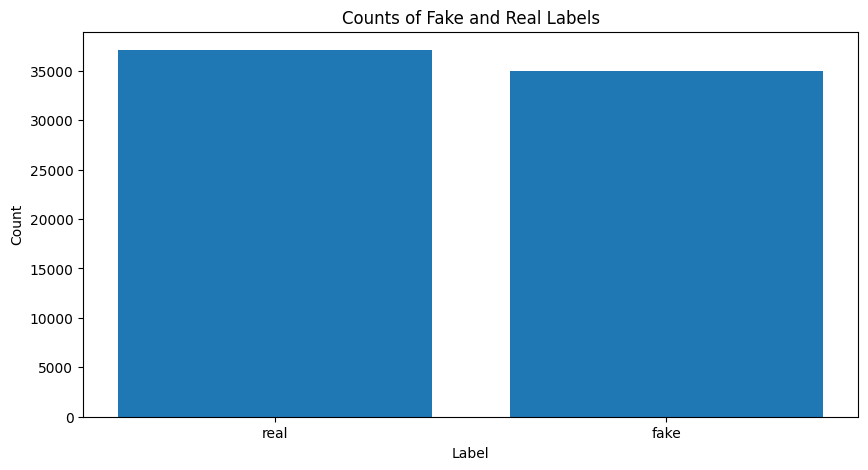

In [5]:
val_counts = dataset['label'].value_counts()
print(val_counts)
plt.figure(figsize=(10, 5))

# Create bar chart
plt.bar(["real", "fake"], val_counts.values)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Fake and Real Labels')

# Show plot
plt.show()

In [6]:
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
dataset = dataset[dataset['text'].notna()]
len(dataset)

72095

In [8]:
data = dataset[['title','text','label']]
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [10]:
data.dropna(subset=['label'], inplace=True)
data['label'] = data['label'].replace({'Real': 1, 'Fake': 0})
data['label'] = data['label'].astype(int)

In [11]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',str(text))

data['text'] = data['text'].apply(remove_url)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',str(text))

data['text'] = data['text'].apply(remove_html)

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(text)) # no emoji

data['text'] = data['text'].apply(remove_emoji)

In [12]:
def processing(df):
    df = df.fillna('No info', axis=1)
    df['text'] = df.title  + df.text
    return df

data = processing(data)

In [13]:
x = list(data['text'])
y = list(data['label'])


In [14]:
print(data.loc[:, :].isnull().sum())

title    0
text     0
label    0
dtype: int64


In [15]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Creating a PyTorch tensor dataset

The following function is defined to make a PyTorch tensor dataset. The parameter given to the function are `X` which represents the comments to be classified, `y` containing the gold labels for the comments, and a `tokenizer`. The tokenizer we are using is Distil Bert Tokenizer and we are using pretrained format by using the model we got from the `Hugging Face Transformers` library.

In the for loop, we are encoding the dataset using the tokenizer. THe maximum length is 512 and if a sentence is less than that, it is padded to 512 and if it more than 512, it is truncated. The encoded_dict return the input_ids and attention mask.

The `input_ids` is a list that stores the tokenized and encoded input_ids. The `attention_mask` is a binary mask that indicates which tokens in the input sequence are actual tokens and which are padding tokens. It is used so that during training the padding tokens can be ignored.

The next for loop is converting the labels to a pyTorch float type tensor.

Next we are stacking each list to be able to make the dataset

Lastly, using these stacked `input ids`, `attention masks` and these `label` tensors we are creating the tensor dataset using the inbuilt `TensorDataset` and returning this dataset.

In [25]:
def get_TensorDataset(X,y, tokenizer):

    input_ids = []
    attention_mask = []
    y_tensor = []


    X = X
    y = y
    tokenized_data = tokenizer(
        X,
        max_length=512,          # Pad or truncate all sentences to the same length
        truncation=True,         # Explicitly ask to truncate longer sequences
        padding=True,    # Pad shorter sequences
        return_tensors='pt'      # Return PyTorch tensors
    )

    y_tensor = torch.tensor(list(y), dtype=torch.long)


    tensor = TensorDataset(tokenized_data['input_ids'], tokenized_data['attention_mask'], y_tensor)

    return tensor


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:

y_train = torch.tensor(list(y_train), dtype=torch.long)
y_val = torch.tensor(list(y_val), dtype=torch.long)

train_tensor = get_TensorDataset(X_train, y_train, tokenizer=tokenizer)
val_tensor = get_TensorDataset(X_val, y_val, tokenizer=tokenizer)




## Getting the Evaluation Metrics

The functions in the next few cells are used to get the accuracy, precision, recall, and confusion matrix for our model. We are using the `sklearn.metrics` module to get these scores.


In [2]:
def get_Accuracy(y_true,y_pred):
    y_true = np.array(y_true)
    preds = y_pred
    preds = np.array(preds)

    exact_match = np.sum(preds == y_true)
    overall_acc = exact_match / len(y_true)
    return {
        'overall': overall_acc
    }

In [3]:
def get_Prec(y_true , y_pred):
    y_true = np.array(y_true)
    preds = y_pred


    overall_prec = precision_score(y_true, preds, average='micro')


    return {
        'overall': overall_prec
    }

In [4]:
def get_Recall(y_true , y_pred):
    y_true = np.array(y_true)
    preds = y_pred


    overall_recall = recall_score(y_true, preds, average='micro')


    return {
        'overall': overall_recall
    }

In [5]:
def get_f1(y_true,y_pred):
    y_true = np.array(y_true)
    preds = y_pred

    micro_f1 = f1_score(y_true, preds, average='micro')

    return {
        'overall': micro_f1
    }

In [6]:
def get_Confusion_Matrices(y_true , y_pred):
    y_true = np.array(y_true)
    preds = y_pred

    cf = confusion_matrix(y_true,preds)




    return {
        'cf': cf,
    }

In [14]:
def make_heat_map(cf):
    plt.figure(figsize=(8,4))
    sns.heatmap(cf,xticklabels=['Fake','Real'], yticklabels = ['Fake','Real'], annot = True, cmap="cividis")
    plt.title('Confusion matrix')
    plt.xlabel("Gold Labels")
    plt.ylabel("Model Predictions")
    plt.show()

In [15]:
def  overall_eval(y_true , y_pred):
    accuracy = get_Accuracy(y_true,y_pred)
    precision = get_Prec(y_true,y_pred)
    recall = get_Recall(y_true,y_pred)
    f1 = get_f1(y_true,y_pred)
    cf = get_Confusion_Matrices(y_true,y_pred)

    print("\n Overall Stats: \n")
    print("accuracy: ", accuracy['overall'])
    print(" Micro precision : ", precision['overall'])
    print(" Micro recall: ", recall['overall'])
    print(" Micro F1: ", f1['overall'])
    print('\n----------------------------------------------------------------------------------------------------------------------------------\n')
    make_heat_map(cf['cf'])


In [ ]:
# Load the TensorDataset from the pickle file
with open('train_tensor_new.pkl', 'rb') as file:
    train_tensor = pickle.load(file)

with open('val_tensor_new.pkl', 'rb') as file:
    val_tensor = pickle.load(file)

batch_size = 64


train_dataloader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Initializing the model
- loss = CrossEntropyLoss
- optimizer = Adam, lr = 0.00005
- epochs = 2
- scheduler

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2, num_hidden_layers=12, hidden_size=768, output_attentions=True)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {'params': model.bert.parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 5e-5}
], lr=5e-5)

epochs = 1


scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def validate(model,criterion):
    model.eval()
    val_accuracy = 0
    val_loss = 0
    for _,batch in tqdm(enumerate(val_dataloader)):
        input_ids, mask, true_labels = batch
        input_ids, mask, true_labels = input_ids.to(device), mask.to(device), true_labels.to(device)
        # true_labels = true_labels.unsqueeze(1)
        with torch.no_grad():
          out_logits = model(input_ids, attention_mask=mask, labels=true_labels)
        loss = out_logits.loss
        val_loss += loss.item()
        logits = out_logits.logits
        preds = torch.argmax(logits, dim=1)
        accuracy = get_Accuracy(true_labels, preds)
        # accuracy = get_Accuracy(true_labels,logits,0.4)
        val_accuracy +=  accuracy['overall']
    return val_accuracy/len(val_dataloader) , val_loss/len(val_dataloader)

### Training the model
- model trained for epochs defined above
- validation and stats after each epoch
- overall results give great stats

In [ ]:
def model_train(epochs, model, optimizer,criterion,scheduler):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        model.train()
        for _,data in tqdm(enumerate(train_dataloader)):
            input_ids, mask, true_labels = data
            input_ids, mask, true_labels = input_ids.to(device), mask.to(device), true_labels.to(device)

            optimizer.zero_grad()
            out_logits = model(input_ids=input_ids, attention_mask=mask, labels=true_labels)
            loss = out_logits.loss
            train_loss += loss.item()
            loss.backward()

            logits = out_logits.logits
            preds = torch.argmax(logits, dim=1)
            accuracy = get_Accuracy(true_labels, preds)
            train_accuracy += accuracy['overall']

            if _%40==0:
                print(f'Epoch: {epoch},Batch {_}, Loss:  {loss.item()}, Accuracy: {train_accuracy/(_+1)}')
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        scheduler.step()
        val_accuracy,val_loss = validate(model, criterion)


        print(f'Epoch: {epoch+1}, Train Loss:  {train_loss/(len(train_dataloader))}, Train Accuracy: {train_accuracy/(len(train_dataloader))},  Val Loss:  {val_loss}, Val Accuracy: {val_accuracy}')


In [ ]:
model_train(epochs,model,optimizer,criterion,scheduler)

0it [00:00, ?it/s]

Epoch: 0,Batch 0, Loss:  0.6749188303947449, Accuracy: 0.53125


41it [23:03, 33.68s/it]

Epoch: 0,Batch 40, Loss:  0.11127965897321701, Accuracy: 0.9054878048780488


81it [45:54, 34.47s/it]

Epoch: 0,Batch 80, Loss:  0.057729922235012054, Accuracy: 0.9390432098765432


120it [1:08:21, 34.52s/it]

Epoch: 0,Batch 120, Loss:  0.07365534454584122, Accuracy: 0.952995867768595


160it [1:31:32, 34.83s/it]

Epoch: 0,Batch 160, Loss:  0.01288165058940649, Accuracy: 0.9586568322981367


201it [1:55:18, 34.77s/it]

Epoch: 0,Batch 200, Loss:  0.03655082732439041, Accuracy: 0.9636194029850746


240it [2:18:00, 34.60s/it]

Epoch: 0,Batch 240, Loss:  0.12467604130506516, Accuracy: 0.9677126556016598


281it [2:41:57, 34.96s/it]

Epoch: 0,Batch 280, Loss:  0.018099283799529076, Accuracy: 0.970807384341637


321it [3:05:17, 34.81s/it]

Epoch: 0,Batch 320, Loss:  0.00726468488574028, Accuracy: 0.9730334890965732


361it [3:28:35, 34.82s/it]

Epoch: 0,Batch 360, Loss:  0.04665599390864372, Accuracy: 0.9745931440443213


401it [3:51:58, 34.98s/it]

Epoch: 0,Batch 400, Loss:  0.04563530534505844, Accuracy: 0.9762312967581047


440it [4:14:57, 35.32s/it]

Epoch: 0,Batch 440, Loss:  0.001437528058886528, Accuracy: 0.9770408163265306


480it [4:38:28, 35.26s/it]

Epoch: 0,Batch 480, Loss:  0.005015000235289335, Accuracy: 0.9783653846153846


520it [5:01:57, 35.26s/it]

Epoch: 0,Batch 520, Loss:  0.000685609586071223, Accuracy: 0.979186660268714


560it [5:25:28, 35.27s/it]

Epoch: 0,Batch 560, Loss:  0.01091718953102827, Accuracy: 0.9798629679144385


601it [5:50:07, 36.50s/it]

Epoch: 0,Batch 600, Loss:  0.01198764331638813, Accuracy: 0.9806052412645591


641it [6:14:27, 36.41s/it]

Epoch: 0,Batch 640, Loss:  0.014436366967856884, Accuracy: 0.9813036271450858


680it [6:38:16, 36.63s/it]

Epoch: 0,Batch 680, Loss:  0.016096901148557663, Accuracy: 0.9818970264317181


720it [7:02:42, 36.63s/it]

Epoch: 0,Batch 720, Loss:  0.0025363413151353598, Accuracy: 0.9824679264909847


721it [7:03:16, 35.22s/it]
181it [40:04, 13.28s/it]


Epoch: 0, Train Loss:  0.050541392715181835, Train Accuracy: 0.9824679264909847,  Val Loss:  0.016999408614613343, Val Accuracy: 0.9948204419889503


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_1epoch.pth')


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2, num_hidden_layers=12, hidden_size=768, output_attentions=True)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {'params': model.bert.parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 5e-5}
], lr=5e-5)

epochs = 1


scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

checkpoint = torch.load('model_1epoch.pth')
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:80: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_train(epochs,model,optimizer,criterion,scheduler)

1it [00:32, 32.45s/it]

Epoch: 0,Batch 0, Loss:  0.004289228469133377, Accuracy: 1.0


40it [21:52, 33.09s/it]

Epoch: 0,Batch 40, Loss:  0.034048616886138916, Accuracy: 0.9965701219512195


80it [44:02, 33.48s/it]

Epoch: 0,Batch 80, Loss:  0.00035296837450005114, Accuracy: 0.9965277777777778


120it [1:06:27, 33.79s/it]

Epoch: 0,Batch 120, Loss:  0.005528649780899286, Accuracy: 0.9966425619834711


161it [1:29:29, 33.63s/it]

Epoch: 0,Batch 160, Loss:  0.000908857153262943, Accuracy: 0.9967003105590062


201it [1:52:00, 33.74s/it]

Epoch: 0,Batch 200, Loss:  0.021883519366383553, Accuracy: 0.9969682835820896


241it [2:14:39, 33.85s/it]

Epoch: 0,Batch 240, Loss:  0.0012656074250116944, Accuracy: 0.9970176348547718


281it [2:37:12, 33.56s/it]

Epoch: 0,Batch 280, Loss:  0.006685100495815277, Accuracy: 0.9971085409252669


321it [2:59:52, 33.89s/it]

Epoch: 0,Batch 320, Loss:  0.0002134278474841267, Accuracy: 0.9971281152647975


360it [3:21:56, 34.02s/it]

Epoch: 0,Batch 360, Loss:  0.00024128108634613454, Accuracy: 0.9972731994459834


401it [3:45:11, 34.12s/it]

Epoch: 0,Batch 400, Loss:  0.0002874880738090724, Accuracy: 0.9973114089775561


440it [4:07:28, 34.08s/it]

Epoch: 0,Batch 440, Loss:  0.041238076984882355, Accuracy: 0.9972009637188208


480it [4:30:14, 34.17s/it]

Epoch: 0,Batch 480, Loss:  0.0001794314302969724, Accuracy: 0.9972713097713097


520it [4:53:00, 34.02s/it]

Epoch: 0,Batch 520, Loss:  0.00017879247025121003, Accuracy: 0.9973308541266794


561it [5:16:22, 34.20s/it]

Epoch: 0,Batch 560, Loss:  0.00021561264293268323, Accuracy: 0.9974097593582888


600it [5:38:54, 35.35s/it]

Epoch: 0,Batch 600, Loss:  0.000315606506774202, Accuracy: 0.9975301580698835


640it [6:02:36, 35.81s/it]

Epoch: 0,Batch 640, Loss:  0.003464328357949853, Accuracy: 0.9975136505460218


681it [6:26:46, 35.29s/it]

Epoch: 0,Batch 680, Loss:  0.00019561157387215644, Accuracy: 0.997590859030837


720it [6:49:49, 35.61s/it]

Epoch: 0,Batch 720, Loss:  0.004165420774370432, Accuracy: 0.9976378294036061


721it [6:50:23, 34.15s/it]
181it [38:07, 12.64s/it]


Epoch: 1, Train Loss:  0.00782968669266914, Train Accuracy: 0.9976378294036061,  Val Loss:  0.01346368342903327, Val Accuracy: 0.9962016574585635


In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict()
}, 'model_2epoch.pth')

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [26]:
# train_tensor = get_TensorDataset(X_train, y_train, tokenizer=tokenizer)
test_tensor = get_TensorDataset(X_test, y_test, tokenizer=tokenizer)


with open('test_tensor_new.pkl', 'wb') as file:
    pickle.dump(test_tensor, file)



In [10]:
with open('test_tensor_new.pkl', 'rb') as file:
    test_tensor = pickle.load(file)

In [11]:

test_dataloader = DataLoader(test_tensor, batch_size=64, shuffle=True)


### Testing

In [12]:
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2, num_hidden_layers=12, hidden_size=768, output_attentions=True)
  model.to(device)

  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam([
      {'params': model.bert.parameters(), 'lr': 5e-5},
      {'params': model.classifier.parameters(), 'lr': 5e-5}
  ], lr=5e-5)

  epochs = 1


  scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

  checkpoint = torch.load('model_2epoch.pth')
  model.load_state_dict(checkpoint['model_state_dict'], strict=False)
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
all_pred = []
all_true_labels = []
model.eval()
with torch.inference_mode():
  for _, data in tqdm(enumerate(test_dataloader)):
           input_ids, mask, true_labels = data
           input_ids, mask, true_labels = input_ids.to(device), mask.to(device), true_labels.to(device)
           all_true_labels.append(true_labels)
          #  print(np.shape(all_true_labels))
           with torch.no_grad():
            logits = model(input_ids, attention_mask=mask, labels=true_labels)
            # probs = torch.sigmoid(logits) > 0.4
           logits = logits.logits
           preds = torch.argmax(logits, dim=1)
           all_pred.append(preds)



226it [46:47, 12.42s/it]


In [14]:
all_pred = torch.cat(all_pred, dim=0)
all_true_labels = torch.cat(all_true_labels, dim=0)


In [15]:
with open('all_pred.pkl', 'wb') as file:
    pickle.dump(all_pred, file)

with open('all_true_labels.pkl', 'wb') as file:
    pickle.dump(all_true_labels, file)

In [10]:
with open('all_pred.pkl', 'rb') as file:
    all_pred = pickle.load(file)

with open('all_true_labels.pkl', 'rb') as file:
    all_true_labels = pickle.load(file)

In [9]:
import tensorflow as tf
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count

### Test Stats
- all stats are above 99%


 Overall Stats: 

accuracy:  0.9949372355919274
 Micro precision :  0.9949372355919274
 Micro recall:  0.9949372355919274
 Micro F1:  0.9949372355919274

----------------------------------------------------------------------------------------------------------------------------------



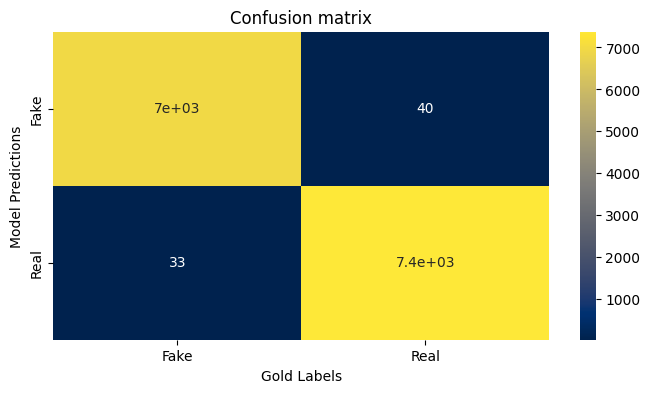

In [16]:
overall_eval(all_true_labels, all_pred)